In [16]:
import sys
sys.path.append( '../Model/' )
from torch_geometric.datasets.sbm_dataset import StochasticBlockModelDataset
import torch
from torch_geometric.utils import to_networkx
import networkx as nx
from vq_vae import *
import matplotlib.pyplot as plt
from torch_geometric.utils import negative_sampling


/Users/liushuhan/opt/anaconda3/lib/python3.9/site-packages/torch_geometric/data/storage.py:271: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'edge_index', 'y'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  warnings.warn(


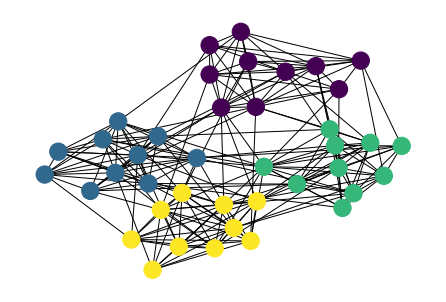

In [17]:
# mat = [[0.9,0.1,0.1,0.1,0.1], [0.1,0.9,0.1,0.1,0.1], [0.1,0.1,0.9,0.1,0.1], [0.1,0.1,0.1,0.9,0.1], [0.1,0.1,0.1,0.1,0.9]]
# size = [10,10,10,10,10]
mat = [[0.9,0.1,0.1,0.1], [0.1,0.9,0.1,0.1], [0.1,0.1,0.9,0.1], [0.1,0.1,0.1,0.9]]
size = [10,10,10,10]
# mat = [[0.8,0.1,0.1], [0.1,0.8,0.1], [0.1,0.1,0.8]]
# size = [500,500,500]
gen = StochasticBlockModelDataset("data", block_sizes=torch.tensor(size), edge_probs=torch.tensor(mat), is_undirected=True)
data = gen.data
G = to_networkx(data, to_undirected=True)
nx.draw(G, node_color=data.y)
# Fix negative edges
# neg_edge_index = negative_sampling(data.edge_index, num_neg_samples=sum(size)*10)
# torch.save(neg_edge_index, "data//edge_neg")
neg_edge_index = torch.load("data//edge_neg")

In [18]:
def train_plot_model(prior_beta, beta, lr, epochs=1000):
    hidden_dim = 64
    latent_dim = 64
    num_latent = 30
    prior_alpha  = 1
    input_dim = 15
    torch.manual_seed(2000)
    # Initial data
    data.x = torch.randn(sum(size),input_dim)
    # model
    torch.manual_seed(2000)
    model = sb_vq_vae(input_dim, hidden_dim, latent_dim, num_latent, beta, prior_alpha, prior_beta)

    # move to GPU (if available)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    x = data.x.to(device)
    edge_index = data.edge_index.to(device)
    # inizialize the optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr)

    def train(epoch):
        model.train()
        latent_embedding, quantized_latents, codebook, recon_loss, kl_prior1_loss, pi, v, vq_loss = model(x, edge_index, neg_edge_index=neg_edge_index)
        optimizer.zero_grad()
        loss =   recon_loss +   kl_prior1_loss  + vq_loss # +  0.001 * kl_cat_loss  + 0.001 * torch.abs(kl_kumar_loss)
        loss.backward()
        optimizer.step()
        # for name, params in model.named_parameters():
        #     print(name, eval('model.'+name).grad)
        # for name, parma in model.named_parameters():
        #     print(name, eval('model.'+name).grad, parma.shape)
        return float(loss), latent_embedding, quantized_latents, codebook, recon_loss, kl_prior1_loss, pi, v, vq_loss

    loss_min = torch.tensor([100000]) 
    rec = []
    prior_rec = []
    recon_rec = []
    vq_loss_rec = []

    for epoch in range(1, epochs + 1):
        loss, latent_embedding, quantized_latents, codebook, recon_loss, kl_prior1_loss, pi, v, vq_loss = train(epoch)
        rec.append(loss)
        prior_rec.append(float(kl_prior1_loss))
        recon_rec.append(float(recon_loss))
        vq_loss_rec.append(float(vq_loss))
        # for name, param in model.named_parameters():
        #     print(name, eval('model.'+name).grad)
        if loss < loss_min:
            loss_min = loss
            model.eval()
            latent_embedding_min, quantized_latents_min, codebook_min, recon_loss_min, kl_prior1_loss_min, pi_min, v_min, vq_loss_min = model(x, edge_index, neg_edge_index=neg_edge_index)

        if epoch % 100 == 0:
            print('Epoch:{:03d}, loss:{:.4f}'.format(epoch, loss))
            # print(quantized_latents[0,:])
            # for p in model.parameters():
            #     print(p[:,0])
    plt.plot(prior_rec)
    plt.plot(recon_rec)
    plt.plot(vq_loss_rec)
    model.eval()
    _, color = torch.unique(torch.sum(torch.round(quantized_latents_min, decimals=4), dim=1), return_inverse=True)
    return prior_rec, recon_rec, vq_loss_rec, color
    
def purity(color, label):
    pur = torch.zeros(torch.max(color)+1, torch.max(label)+1)
    for i in range(torch.max(color)+1):
        for j in range(torch.max(label)+1):
            pur[i,j] = torch.sum((color==i) & (label==j)) / torch.sum(color==i)
    return pur



In [19]:
lr = 1e-2
epochs = 1000

/Users/liushuhan/opt/anaconda3/lib/python3.9/site-packages/torch/distributions/distribution.py:159: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)


Epoch:100, loss:3.3333
Epoch:200, loss:2.8893
Epoch:300, loss:2.8181
Epoch:400, loss:2.8050
Epoch:500, loss:2.8093
Epoch:600, loss:2.8041
Epoch:700, loss:2.8053
Epoch:800, loss:2.7996
Epoch:900, loss:2.8020
Epoch:1000, loss:2.7987
tensor([[1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.]])
tensor(4)
1.517549753189087 1.2796539068222046 0.001533797476440668


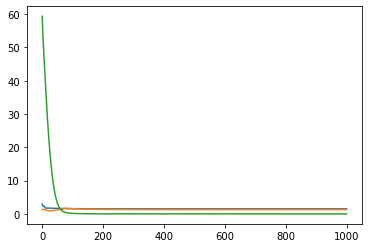

In [20]:
prior_rec, recon_rec, vq_loss_rec, color = train_plot_model(prior_beta=0.5, beta=0.25, lr=lr, epochs=epochs)
print(purity(color, data.y))
print(torch.max(color))
print(prior_rec[len(prior_rec)-1], recon_rec[len(prior_rec)-1], vq_loss_rec[len(prior_rec)-1])

Epoch:100, loss:2.6630
Epoch:200, loss:1.9610
Epoch:300, loss:1.7714
Epoch:400, loss:1.7201
Epoch:500, loss:1.6962
Epoch:600, loss:1.6927
Epoch:700, loss:1.6916
Epoch:800, loss:1.6476
Epoch:900, loss:1.6477
Epoch:1000, loss:1.6485
tensor([[0., 1., 0., 0.],
        [0., 0., 0., 1.],
        [1., 0., 0., 0.],
        [0., 0., 1., 0.]])
tensor(3)
0.8166811466217041 0.8297069072723389 0.0020987745374441147


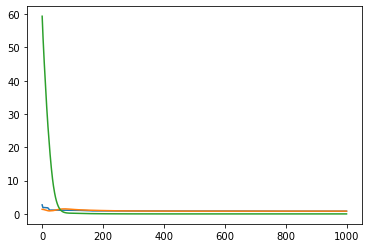

In [21]:
prior_rec, recon_rec, vq_loss_rec, color = train_plot_model(prior_beta=1, beta=0.25, lr=lr, epochs=epochs)
print(purity(color, data.y))
print(torch.max(color))
print(prior_rec[len(prior_rec)-1], recon_rec[len(prior_rec)-1], vq_loss_rec[len(prior_rec)-1])

Epoch:100, loss:3.2837
Epoch:200, loss:2.4719
Epoch:300, loss:2.4610
Epoch:400, loss:2.3879
Epoch:500, loss:2.3993
Epoch:600, loss:2.3931
Epoch:700, loss:2.3973
Epoch:800, loss:2.3066
Epoch:900, loss:1.9883
Epoch:1000, loss:1.9879
tensor([[0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 1., 0.]])
tensor(5)
0.9327622056007385 1.0448479652404785 0.010289378464221954


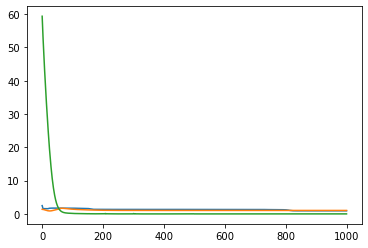

In [22]:
prior_rec, recon_rec, vq_loss_rec, color = train_plot_model(prior_beta=1.5, beta=0.25, lr=lr, epochs=epochs)
print(purity(color, data.y))
print(torch.max(color))
print(prior_rec[epochs-1], recon_rec[epochs-1], vq_loss_rec[epochs-1])

Epoch:100, loss:2.8924
Epoch:200, loss:2.2279
Epoch:300, loss:2.1312
Epoch:400, loss:2.0963
Epoch:500, loss:1.8448
Epoch:600, loss:1.8681
Epoch:700, loss:1.8432
Epoch:800, loss:1.8491
Epoch:900, loss:1.8388
Epoch:1000, loss:1.8346
tensor([[0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.]])
tensor(5)
0.7905095815658569 1.0379667282104492 0.006172840017825365


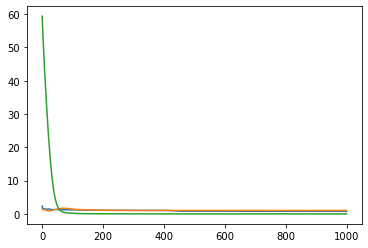

In [23]:
prior_rec, recon_rec, vq_loss_rec, color = train_plot_model(prior_beta=2.0, beta=0.25, lr=lr, epochs=epochs)
print(purity(color, data.y))
print(torch.max(color))
print(prior_rec[epochs-1], recon_rec[epochs-1], vq_loss_rec[epochs-1])

Epoch:100, loss:2.2110
Epoch:200, loss:1.6819
Epoch:300, loss:1.4948
Epoch:400, loss:1.4410
Epoch:500, loss:1.4369
Epoch:600, loss:1.4365
Epoch:700, loss:1.4356
Epoch:800, loss:1.4355
Epoch:900, loss:1.4354
Epoch:1000, loss:1.4354
tensor([[0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [1., 0., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.]])
tensor(6)
0.6121819615364075 0.8230775594711304 0.00013623891572933644


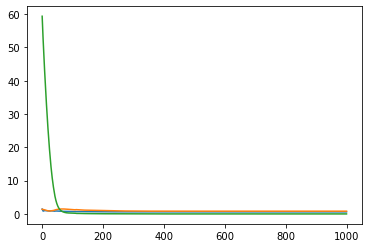

In [24]:
prior_rec, recon_rec, vq_loss_rec, color = train_plot_model(prior_beta=5.0, beta=0.25, lr=lr, epochs=epochs)
print(purity(color, data.y))
print(torch.max(color))
print(prior_rec[epochs-1], recon_rec[epochs-1], vq_loss_rec[epochs-1])

Epoch:100, loss:2.1635
Epoch:200, loss:1.5855
Epoch:300, loss:1.4468
Epoch:400, loss:1.4258
Epoch:500, loss:1.3903
Epoch:600, loss:1.3846
Epoch:700, loss:1.3830
Epoch:800, loss:1.3829
Epoch:900, loss:1.3874
Epoch:1000, loss:1.3783
tensor([[0., 1., 0., 0.],
        [0., 0., 0., 1.],
        [1., 0., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.]])
tensor(6)
0.6047492027282715 0.7721407413482666 0.0013719479320570827


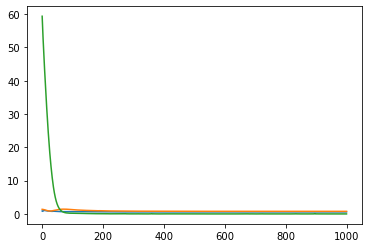

In [25]:
prior_rec, recon_rec, vq_loss_rec, color = train_plot_model(prior_beta=10.0, beta=0.25, lr=lr, epochs=epochs)
print(purity(color, data.y))
print(torch.max(color))
print(prior_rec[epochs-1], recon_rec[epochs-1], vq_loss_rec[epochs-1])

Epoch:100, loss:2.2919
Epoch:200, loss:1.8286
Epoch:300, loss:1.6501
Epoch:400, loss:1.6028
Epoch:500, loss:1.5940
Epoch:600, loss:1.5887
Epoch:700, loss:1.5909
Epoch:800, loss:1.5886
Epoch:900, loss:1.5866
Epoch:1000, loss:1.6220
tensor([[0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [1., 0., 0., 0.],
        [0., 0., 1., 0.]])
tensor(5)
0.7724012136459351 0.8099994659423828 0.039576977491378784


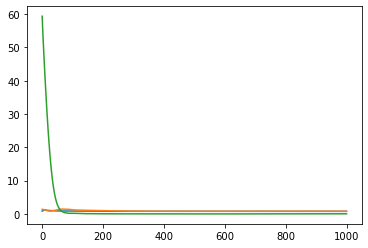

In [26]:
prior_rec, recon_rec, vq_loss_rec, color = train_plot_model(prior_beta=20, beta=0.25, lr=lr, epochs=epochs)
print(purity(color, data.y))
print(torch.max(color))
print(prior_rec[epochs-1], recon_rec[epochs-1], vq_loss_rec[epochs-1])

Epoch:100, loss:3.2503
Epoch:200, loss:2.8016
Epoch:300, loss:2.6808
Epoch:400, loss:2.6501
Epoch:500, loss:2.6288
Epoch:600, loss:2.6246
Epoch:700, loss:2.6142
Epoch:800, loss:2.6132
Epoch:900, loss:2.6077
Epoch:1000, loss:2.6031
tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.]])
tensor(10)
1.8294651508331299 0.7690123915672302 0.004667060915380716


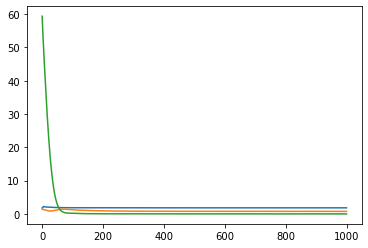

In [27]:
prior_rec, recon_rec, vq_loss_rec, color = train_plot_model(prior_beta=100, beta=0.25, lr=lr, epochs=epochs)
print(purity(color, data.y))
print(torch.max(color))
print(prior_rec[epochs-1], recon_rec[epochs-1], vq_loss_rec[epochs-1])

Epoch:100, loss:4.9494
Epoch:200, loss:4.4773
Epoch:300, loss:4.3805
Epoch:400, loss:4.3552
Epoch:500, loss:4.3364
Epoch:600, loss:4.3214
Epoch:700, loss:4.3178
Epoch:800, loss:4.3154
Epoch:900, loss:4.3096
Epoch:1000, loss:4.2953
tensor([[0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 1., 0.],
        [1., 0., 0., 0.],
        [0., 0., 1., 0.]])
tensor(12)
3.5555169582366943 0.7324903011322021 0.007318058051168919


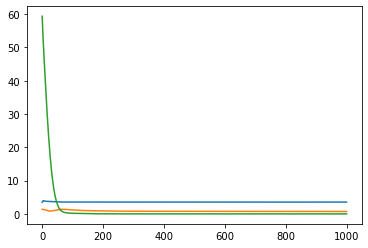

In [29]:
prior_rec, recon_rec, vq_loss_rec, color = train_plot_model(prior_beta=10000, beta=0.25, lr=lr, epochs=epochs)
print(purity(color, data.y))
print(torch.max(color))
print(prior_rec[epochs-1], recon_rec[epochs-1], vq_loss_rec[epochs-1])